<a href="https://colab.research.google.com/github/Rino04/Sentimental-Analysis-of-USA-Airlines/blob/main/Final_Tweets_Analysis_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Understanding

### a) Specifying the Question

> Performing sentiment analysis on people's views towards six United States airlines.


### b) Defining the Metric for Success

Our project will be cinsidered successful if we can effectively build a Neural network model that can give an accuracy of more than 90%.

### c) Understanding the context 


We analyze seven days of data from Twitter regarding customer sentiment for 6 US airlines: American, Delta, Southwest Airlines, United, US Airways, and Virgin America.Then use Tensor Flow to predict the chance of a tweet to be positive,negative or neutral.

### d) Recording the Experimental Design

The following steps will be followed in conducting this analysis:
1. Defining the Question
2. Reading the Data.
3. Data Exploration.
4. Data Cleaning
5. Data Analysis
6. Models
7. Evaluation of the solution
8. Challenging the solution
9. Conclusion

### e) Data Relevance

This will be discussed after the analysis

# Data Exploration

### Importing the libraries

In [1]:
#For data exploration
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# modelling
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,Dense, Dropout, SpatialDropout1D
from tensorflow.keras.layers import Embedding

#For cleaning the tweets
import re
import string
import nltk
nltk.download('stopwords')

from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer
from nltk.stem.lancaster import LancasterStemmer

#for metrics
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score

#warnings
import warnings
warnings.filterwarnings('ignore') 

#wandb
!pip install wandb
import wandb
wandb.login()
import tensorflow as tf
from tensorflow.keras.callbacks import Callback
from wandb.keras import WandbCallback
import random

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
     |████████████████████████████████| 1.6 MB 7.6 MB/s 
     |████████████████████████████████| 133 kB 66.2 MB/s 
     |████████████████████████████████| 97 kB 8.2 MB/s 
     |████████████████████████████████| 170 kB 67.4 MB/s 
     |████████████████████████████████| 63 kB 2.2 MB/s 
  Created wheel for subprocess32: filename=subprocess32-3.5.4-py3-none-any.whl size=6502 sha256=fac17a39f9e59b05311123df7b17399da8ef301ae7670a69f0296997f4fe29bc
  Stored in directory: /root/.cache/pip/wheels/50/ca/fa/8fca8d246e64f19488d07567547ddec8eb084e8c0d7a59226a
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8807 sha256=37740a67210fb1beeb5bd564fd04cc50b1bac6f4ecd4188971c3ab2c41367746
  Stored in directory: /root/.cache/pip/wheels/3e/31/09/fa59cef12cdcfecc627b3d24273699f390e71828921b2cbba2
Successfully built subprocess32 pathtools


<IPython.core.display.Javascript object>

wandb: You can find your API key in your browser here: https://wandb.ai/authorize


wandb: Paste an API key from your profile and hit enter: ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


### Loading and prievew the datasets

In [3]:
# Loading the dataset
df=pd.read_csv('/content/Tweets.csv')

In [4]:
#check the info 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   tweet_id                      14640 non-null  int64  
 1   airline_sentiment             14640 non-null  object 
 2   airline_sentiment_confidence  14640 non-null  float64
 3   negativereason                9178 non-null   object 
 4   negativereason_confidence     10522 non-null  float64
 5   airline                       14640 non-null  object 
 6   airline_sentiment_gold        40 non-null     object 
 7   name                          14640 non-null  object 
 8   negativereason_gold           32 non-null     object 
 9   retweet_count                 14640 non-null  int64  
 10  text                          14640 non-null  object 
 11  tweet_coord                   1019 non-null   object 
 12  tweet_created                 14640 non-null  object 
 13  t

In [5]:
#check the shape 
print('This Spam dataset has ' + str(df.shape[0]) + ' rows, and ' + str(df.shape[1]) + ' columns')

This Spam dataset has 14640 rows, and 15 columns


In [6]:
#Preview the head of train
df=df.rename(columns={'airline_sentiment': 'sentiment'})
df.head()

,tweet_id,sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [7]:
# preview the tail
df.tail()

,tweet_id,sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
14635,569587686496825344,positive,0.3487,NaN,0.0000,American,NaN,KristenReenders,NaN,0,@AmericanAir thank you we got on a different f...,NaN,2015-02-22 12:01:01 -0800,NaN,NaN
14636,569587371693355008,negative,1.0000,Customer Service Issue,1.0000,American,NaN,itsropes,NaN,0,@AmericanAir leaving over 20 minutes Late Flig...,NaN,2015-02-22 11:59:46 -0800,Texas,NaN
14637,569587242672398336,neutral,1.0000,NaN,NaN,American,NaN,sanyabun,NaN,0,@AmericanAir Please bring American Airlines to...,NaN,2015-02-22 11:59:15 -0800,"Nigeria,lagos",NaN
14638,569587188687634433,negative,1.0000,Customer Service Issue,0.6659,American,NaN,SraJackson,NaN,0,"@AmericanAir you have my money, you change my ...",NaN,2015-02-22 11:59:02 -0800,New Jersey,Eastern Time (US & Canada)
14639,569587140490866689,neutral,0.6771,NaN,0.0000,American,NaN,daviddtwu,NaN,0,@AmericanAir we have 8 ppl so we need 2 know h...,NaN,2015-02-22 11:58:51 -0800,"dallas, TX",NaN


# Data Cleaning

### Uniformity

In [8]:
#We shall have the our column names written in pascal format
df.columns=df.columns.str.strip().str.lower().str.replace(' ','_').str.replace('(','').str.replace(')','')
df.columns

Index(['tweet_id', 'sentiment', 'airline_sentiment_confidence',
       'negativereason', 'negativereason_confidence', 'airline',
       'airline_sentiment_gold', 'name', 'negativereason_gold',
       'retweet_count', 'text', 'tweet_coord', 'tweet_created',
       'tweet_location', 'user_timezone'],
      dtype='object')

In [9]:
#Lets check for unique values for each column
for col in list(df):
    print(col)
    print(df[col].unique())
    print("******")

tweet_id
[570306133677760513 570301130888122368 570301083672813571 ...
 569587242672398336 569587188687634433 569587140490866689]
******
sentiment
['neutral' 'positive' 'negative']
******
airline_sentiment_confidence
[1.     0.3486 0.6837 ... 0.6384 0.7094 0.3487]
******
negativereason
[nan 'Bad Flight' "Can't Tell" 'Late Flight' 'Customer Service Issue'
 'Flight Booking Problems' 'Lost Luggage' 'Flight Attendant Complaints'
 'Cancelled Flight' 'Damaged Luggage' 'longlines']
******
negativereason_confidence
[   nan 0.     0.7033 ... 0.6234 0.644  0.7255]
******
airline
['Virgin America' 'United' 'Southwest' 'Delta' 'US Airways' 'American']
******
airline_sentiment_gold
[nan 'negative' 'neutral' 'positive']
******
name
['cairdin' 'jnardino' 'yvonnalynn' ... 'KristenReenders' 'itsropes'
 'sanyabun']
******
negativereason_gold
[nan 'Late Flight\nFlight Attendant Complaints'
 'Late Flight\nLost Luggage' 'Late Flight' 'Customer Service Issue'
 "Can't Tell" 'Cancelled Flight\nCustomer Servic

### Completeness

In [10]:
#check for null values
df.isnull().sum()
#We shall drop the null values

tweet_id                            0
sentiment                           0
airline_sentiment_confidence        0
negativereason                   5462
negativereason_confidence        4118
airline                             0
airline_sentiment_gold          14600
name                                0
negativereason_gold             14608
retweet_count                       0
text                                0
tweet_coord                     13621
tweet_created                       0
tweet_location                   4733
user_timezone                    4820
dtype: int64

In [11]:
#Getting the percentage of null values in each columns
## We check how many columns have missing values
#---
#
def show_missing(dataframe_name):
  missing_all= dataframe_name.columns[df.isnull().any()].tolist()
  more_than_zero=dataframe_name[missing_all].isnull().sum().sort_values(ascending=False)
  percentage=more_than_zero/dataframe_name.shape[0]*100 
  return percentage 
show_missing(df)

negativereason_gold          99.781421
airline_sentiment_gold       99.726776
tweet_coord                  93.039617
negativereason               37.308743
user_timezone                32.923497
tweet_location               32.329235
negativereason_confidence    28.128415
dtype: float64

In [12]:
#We shall drop the columns with more than 50% null values
df=df.drop(columns={'negativereason_gold', 'negativereason_gold', 'tweet_coord'})

### Consistency 

In [13]:
#we will look for the number of rows with duplicate records
print('Number of rows with duplicated values',df.duplicated().sum())

#we then drop the rows with duplicated records
df.drop_duplicates(inplace=True)
print('After dropping there are',df.duplicated().sum(), "Duplicated rows")

print('Shape of dataframe after dropping duplicated rows', df.shape)

Number of rows with duplicated values 36
After dropping there are 0 Duplicated rows
Shape of dataframe after dropping duplicated rows (14604, 13)


# Exploratory Data Analysis

In [14]:
#Get the statistical summaries
df.describe(include='all')

,tweet_id,sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,retweet_count,text,tweet_created,tweet_location,user_timezone
count,1.460400e+04,14604,14604.000000,9159,10503.000000,14604,40,14604,14604.000000,14604,14604,9881,9790
unique,NaN,3,NaN,10,NaN,6,3,7701,NaN,14427,14247,3081,85
top,NaN,negative,NaN,Customer Service Issue,NaN,United,negative,JetBlueNews,NaN,@united thanks,2015-02-24 09:54:34 -0800,"Boston, MA",Eastern Time (US & Canada)
freq,NaN,9159,NaN,2904,NaN,3822,32,63,NaN,6,5,157,3738
mean,5.692157e+17,NaN,0.899923,NaN,0.637644,NaN,NaN,NaN,0.082786,NaN,NaN,NaN,NaN
std,7.782567e+14,NaN,0.162955,NaN,0.330380,NaN,NaN,NaN,0.746647,NaN,NaN,NaN,NaN
min,5.675883e+17,NaN,0.335000,NaN,0.000000,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN
25%,5.685581e+17,NaN,0.692300,NaN,0.360500,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN
50%,5.694728e+17,NaN,1.000000,NaN,0.670500,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN
75%,5.698885e+17,NaN,1.000000,NaN,1.000000,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN


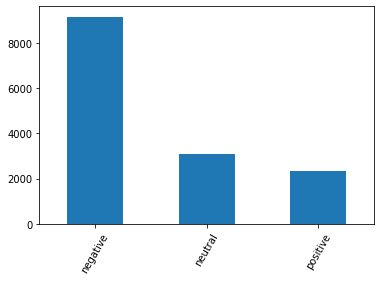

In [15]:
#Visulize the sentiments
df['sentiment'].value_counts().plot(kind='bar', rot=60)

From the histogram,we can conclude that majority of the sentiments are negative followed by neutral and positive sentiments with the least percentage.

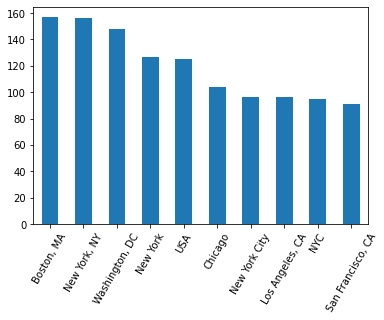

In [16]:
#Visulize the tweet location
df['tweet_location'].value_counts().head(10).plot(kind='bar', rot=60)

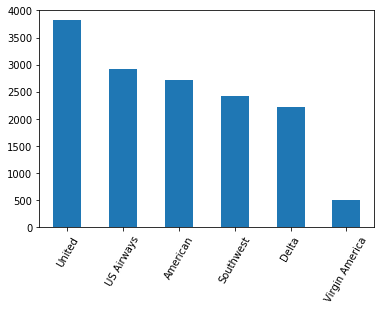

In [17]:
#Visulize the airlines with the most tweets
df['airline'].value_counts().plot(kind='bar', rot=60)

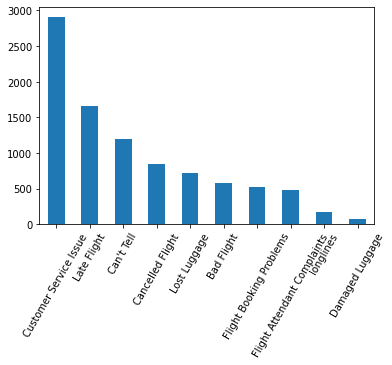

In [18]:
#Visulize the negative reasons
df['negativereason'].value_counts().plot(kind='bar', rot=60)

Majority of the negative tweets were in regards to customer service with 2900 tweets followed by tweets on late flights with 1700tweets 

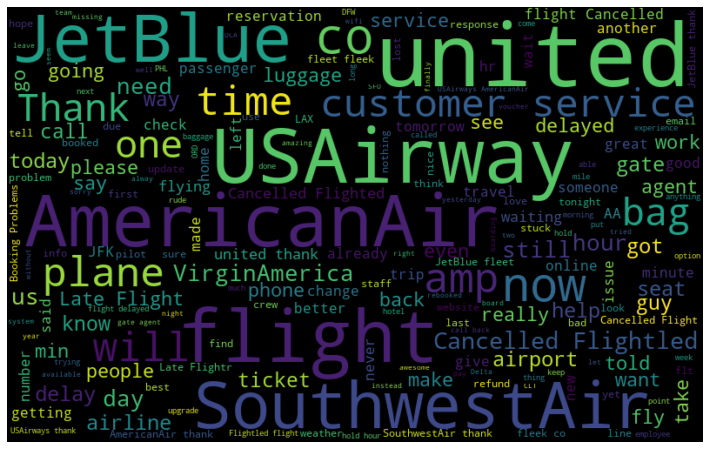

In [19]:
# visulize frequent words
all_words= " ".join(sentence for sentence in df.text)

from wordcloud import WordCloud
wordcloud=WordCloud(width=800, height=500, random_state=42, max_font_size=100).generate(all_words)

#Plot the graph
plt.figure(figsize=(15,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

**Positive Words**

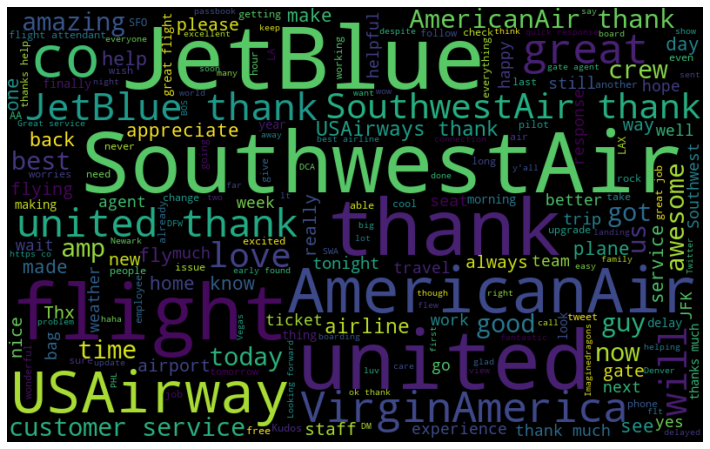

In [20]:
#Frequent words visulization for positive words
#0=negative, 1=neutral, 2=postive
# visulize frequent words
all_words= " ".join(sentence for sentence in df['text'][df['sentiment']=='positive'])

wordcloud=WordCloud(width=800, height=500, random_state=42, max_font_size=100).generate(all_words)

#Plot the graph
plt.figure(figsize=(15,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

**Negative Words**

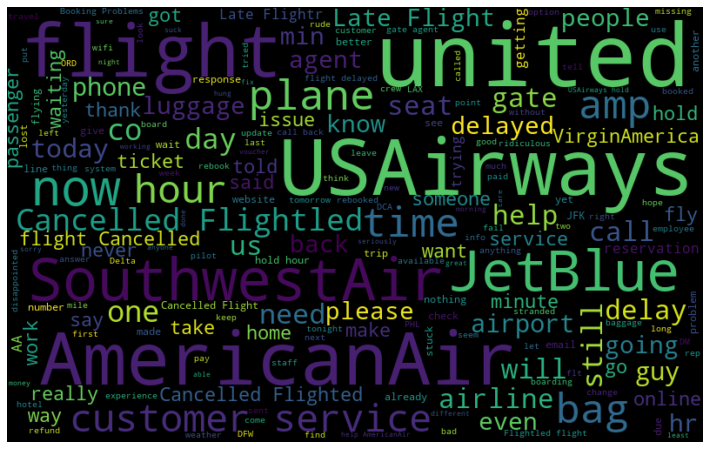

In [21]:
#Frequent words visulization for negative words
# visulize frequent words
all_words= " ".join(sentence for sentence in df['text'][df['sentiment']=='negative'])

wordcloud=WordCloud(width=800, height=500, random_state=42, max_font_size=100).generate(all_words)

#Plot the graph
plt.figure(figsize=(15,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

**Neutral Words**

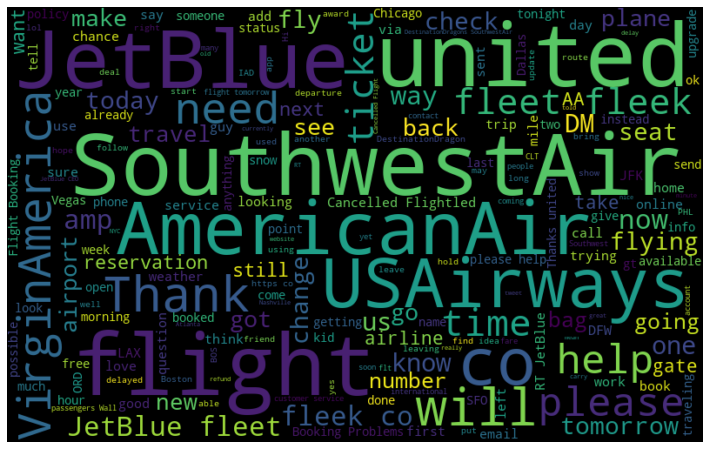

In [22]:
#Frequent words visulization for neutral words
# visulize frequent words
all_words= " ".join(sentence for sentence in df['text'][df['sentiment']=='neutral'])

wordcloud=WordCloud(width=800, height=500, random_state=42, max_font_size=100).generate(all_words)

#Plot the graph
plt.figure(figsize=(15,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

 **Hashtags**

In [23]:
# Extracting the hashtag
def hashtag_extract(tweets):
  hashtags=[]
  #loop words in tweet
  for tweet in tweets:
    ht=re.findall(r"#(\w+)", tweet)
    hashtags.append(ht)
  return hashtags

In [24]:
#Extracts from all the emotions
#Extract for positive
ht_positive= hashtag_extract(df['text'][df['sentiment']=='positive'])
#Extract for negative
ht_negative= hashtag_extract(df['text'][df['sentiment']=='negative'])

In [25]:
#Combine into a single list
ht_positive = sum(ht_positive, [])
ht_negative = sum(ht_negative, [])
print(ht_positive[:5])
print(ht_negative[:5])

['fabulous', 'Seductive', 'stress', '29DaysToGo', 'MoodlitMonday']
['fail', 'VX358', 'noair', 'worstflightever', 'roasted']


**Visulize postive hashtags**

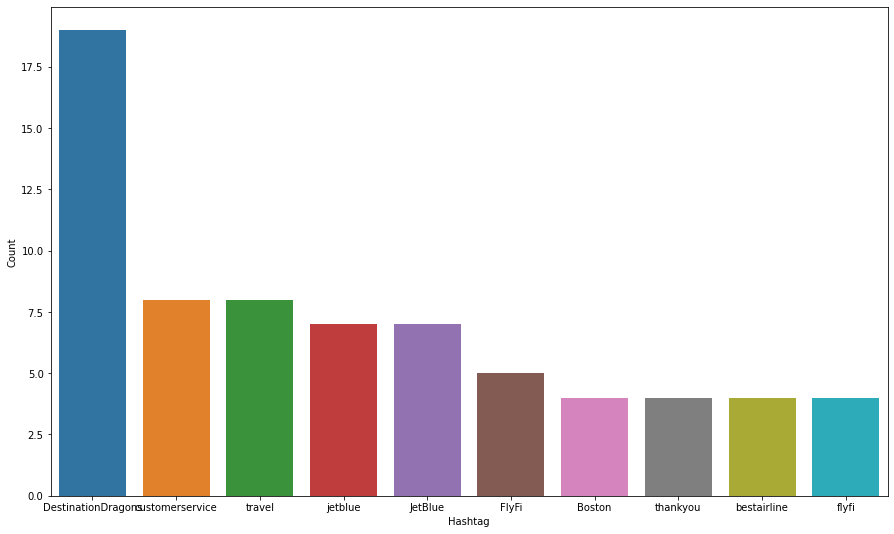

In [26]:
freq=nltk.FreqDist(ht_positive)
d=pd.DataFrame({"Hashtag": list(freq.keys()),
                "Count": list(freq.values())})
#Select top ten hashtags
d=d.nlargest(columns="Count", n=10)
plt.figure(figsize=(15,9))
sns.barplot(data=d, x='Hashtag', y='Count')
plt.show()

**Visulize Negative Hashtags**

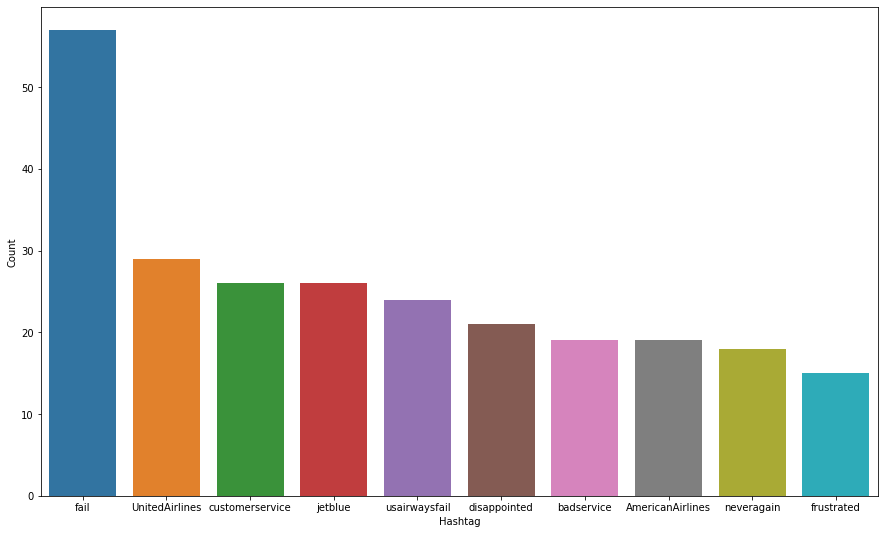

In [27]:
freq=nltk.FreqDist(ht_negative)
d=pd.DataFrame({"Hashtag": list(freq.keys()),
                "Count": list(freq.values())})
#Select top ten hashtags
d=d.nlargest(columns="Count", n=10)
plt.figure(figsize=(15,9))
sns.barplot(data=d, x='Hashtag', y='Count')
plt.show()

# Preprocessing the dataset

In [28]:
#Remove patterns in input txt
def remove_pattern(input_txt, pattern):
  r =re.findall(pattern,input_txt)
  for word in r:
    input_txt =re.sub(word, "", input_txt)
  return input_txt

In [29]:
#Remove twitter handles
df['clean_tweet']= np.vectorize(remove_pattern)(df['text'], "@[\w]*")

In [30]:
df.head()

,tweet_id,sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,retweet_count,text,tweet_created,tweet_location,user_timezone,clean_tweet
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,0,@VirginAmerica What @dhepburn said.,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada),What said.
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,0,@VirginAmerica plus you've added commercials t...,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada),plus you've added commercials to the experien...
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,0,@VirginAmerica I didn't today... Must mean I n...,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada),I didn't today... Must mean I need to take an...
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,0,@VirginAmerica it's really aggressive to blast...,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada),"it's really aggressive to blast obnoxious ""en..."
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,0,@VirginAmerica and it's a really big bad thing...,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada),and it's a really big bad thing about it


In [31]:
#Remove special characters, numbers, punctuations
df['clean_tweet']=df['clean_tweet'].str.replace('[^a-zA-Z#]', " ")
df.head()

,tweet_id,sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,retweet_count,text,tweet_created,tweet_location,user_timezone,clean_tweet
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,0,@VirginAmerica What @dhepburn said.,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada),What said
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,0,@VirginAmerica plus you've added commercials t...,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada),plus you ve added commercials to the experien...
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,0,@VirginAmerica I didn't today... Must mean I n...,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada),I didn t today Must mean I need to take an...
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,0,@VirginAmerica it's really aggressive to blast...,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada),it s really aggressive to blast obnoxious en...
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,0,@VirginAmerica and it's a really big bad thing...,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada),and it s a really big bad thing about it


In [32]:
#remove short words
df['clean_tweet']=df['clean_tweet'].apply(lambda x: " ".join([w for w in x.split() if len(w)>3])) #Removing short words
df.head()

,tweet_id,sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,retweet_count,text,tweet_created,tweet_location,user_timezone,clean_tweet
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,0,@VirginAmerica What @dhepburn said.,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada),What said
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,0,@VirginAmerica plus you've added commercials t...,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada),plus added commercials experience tacky
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,0,@VirginAmerica I didn't today... Must mean I n...,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada),didn today Must mean need take another trip
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,0,@VirginAmerica it's really aggressive to blast...,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada),really aggressive blast obnoxious entertainmen...
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,0,@VirginAmerica and it's a really big bad thing...,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada),really thing about


In [33]:
#individual words considered as words
tokenized_tweet = df['clean_tweet'].apply(lambda x: x.split())
tokenized_tweet.head()

0                                         [What, said]
1        [plus, added, commercials, experience, tacky]
2    [didn, today, Must, mean, need, take, another,...
3    [really, aggressive, blast, obnoxious, enterta...
4                               [really, thing, about]
Name: clean_tweet, dtype: object

In [34]:
#stem the words 
from nltk.stem.porter import PorterStemmer
stemmer = PorterStemmer()

tokenized_tweet= tokenized_tweet.apply(lambda sentence: [stemmer.stem(word) for word in sentence])
tokenized_tweet.head()

0                                         [what, said]
1                   [plu, ad, commerci, experi, tacki]
2    [didn, today, must, mean, need, take, anoth, t...
3    [realli, aggress, blast, obnoxi, entertain, yo...
4                               [realli, thing, about]
Name: clean_tweet, dtype: object

# Modelling

In [36]:
#selecting the required columns
tweet_df = df[['text','sentiment']]
print(tweet_df.shape)
tweet_df.head(5)

(14604, 2)


,text,sentiment
0,@VirginAmerica What @dhepburn said.,neutral
1,@VirginAmerica plus you've added commercials t...,positive
2,@VirginAmerica I didn't today... Must mean I n...,neutral
3,@VirginAmerica it's really aggressive to blast...,negative
4,@VirginAmerica and it's a really big bad thing...,negative


In [37]:
#Get the value counts of the sentiments
df['sentiment'].value_counts()

negative    9159
neutral     3091
positive    2354
Name: sentiment, dtype: int64

In [38]:
#we are only interested in positive and negative sentiments
tweet_df = tweet_df[tweet_df['sentiment'] != 'neutral']
print(tweet_df['sentiment'].value_counts())
tweet_df.head()

negative    9159
positive    2354
Name: sentiment, dtype: int64


,text,sentiment
1,@VirginAmerica plus you've added commercials t...,positive
3,@VirginAmerica it's really aggressive to blast...,negative
4,@VirginAmerica and it's a really big bad thing...,negative
5,@VirginAmerica seriously would pay $30 a fligh...,negative
6,"@VirginAmerica yes, nearly every time I fly VX...",positive


In [39]:
#factorize the sentiment label
sentiment_label = tweet_df.sentiment.factorize()
sentiment_label

(array([0, 1, 1, ..., 0, 1, 1]),
 Index(['positive', 'negative'], dtype='object'))

In [40]:
#Tokinize the tweets
tweet = tweet_df.text.values
tokenizer = Tokenizer(num_words=5000)
tweets=tokenizer.fit_on_texts(tweet)
#getting the vocab_size
vocab_size = len(tokenizer.word_index) + 1
encoded_docs = tokenizer.texts_to_sequences(tweet)
padded_sequence = pad_sequences(encoded_docs, maxlen=200)
print(tokenizer.word_index)

{'to': 1, 'the': 2, 'i': 3, 'a': 4, 'united': 5, 'you': 6, 'for': 7, 'flight': 8, 'and': 9, 'on': 10, 'my': 11, 'usairways': 12, 'americanair': 13, 'is': 14, 'in': 15, 'southwestair': 16, 'of': 17, 'jetblue': 18, 'me': 19, 'your': 20, 'it': 21, 'was': 22, 'not': 23, 'no': 24, 'have': 25, 'at': 26, 'that': 27, 'with': 28, 'this': 29, 'get': 30, 'but': 31, 'be': 32, 'cancelled': 33, 'now': 34, 'thanks': 35, 'service': 36, 'are': 37, 'we': 38, 'from': 39, 'an': 40, 'been': 41, 'just': 42, '2': 43, 'so': 44, 'customer': 45, 'help': 46, 't': 47, 'can': 48, 'time': 49, 'co': 50, 'up': 51, 'hours': 52, 'http': 53, 'do': 54, 'hold': 55, 'they': 56, 'out': 57, 'amp': 58, 'plane': 59, "i'm": 60, 'us': 61, 'all': 62, 'will': 63, 'why': 64, 'thank': 65, 'still': 66, 'our': 67, 'delayed': 68, 'what': 69, 'when': 70, 'how': 71, 'one': 72, "can't": 73, 'flights': 74, 'call': 75, 'gate': 76, 'hour': 77, 'had': 78, 'flightled': 79, 'back': 80, 'if': 81, 'bag': 82, 'would': 83, 'after': 84, 'has': 85, '

### Model

In [41]:
#Intialize
wandb.init(project="Visulize-Sentimental Analysis of Airlines-1")

wandb: Currently logged in as: jack-analyst (use `wandb login --relogin` to force relogin)


In [42]:
#config
config = wandb.config
#Create a tensorflow model
embedding_vector_length = 32
base_model = Sequential() 
base_model.add(Embedding(vocab_size, embedding_vector_length, input_length=200) )
base_model.add(Dense(1, activation='sigmoid')) 
base_model.compile(loss='binary_crossentropy',optimizer='adam', metrics=['accuracy'])  
print(base_model.summary()) 

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 200, 32)           423488    
_________________________________________________________________
dense (Dense)                (None, 200, 1)            33        
Total params: 423,521
Trainable params: 423,521
Non-trainable params: 0
_________________________________________________________________
None


In [43]:
#fit the model
history = base_model.fit(padded_sequence,sentiment_label[0],validation_split=0.2, epochs=5, batch_size=32,callbacks=[WandbCallback()] )

Epoch 1/5
288/288 [==============================] - 3s 7ms/step - loss: 0.5521 - accuracy: 0.7740 - val_loss: 0.4264 - val_accuracy: 0.8565
Epoch 2/5
288/288 [==============================] - 2s 6ms/step - loss: 0.5242 - accuracy: 0.7813 - val_loss: 0.4316 - val_accuracy: 0.8564
Epoch 3/5
288/288 [==============================] - 2s 6ms/step - loss: 0.5228 - accuracy: 0.7814 - val_loss: 0.4250 - val_accuracy: 0.8562
Epoch 4/5
288/288 [==============================] - 2s 6ms/step - loss: 0.5222 - accuracy: 0.7814 - val_loss: 0.4269 - val_accuracy: 0.8562
Epoch 5/5
288/288 [==============================] - 2s 6ms/step - loss: 0.5215 - accuracy: 0.7814 - val_loss: 0.4307 - val_accuracy: 0.8562


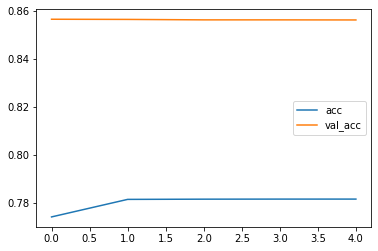

In [44]:
plt.plot(history.history['accuracy'], label='acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.legend()
plt.show()

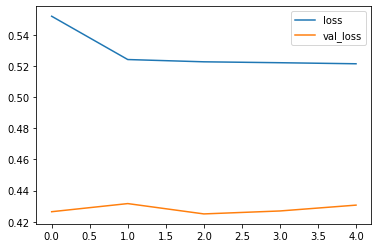

In [45]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

## Hyperparametric Tuning

In [46]:
#Intialize
wandb.init(project="Visulize-Sentimental Analysis of Airlines-2")

epoch,4
loss,0.5215
accuracy,0.78144
val_loss,0.43065
val_accuracy,0.85618
_runtime,28
_timestamp,1629099705
_step,4
best_val_loss,0.425
best_epoch,2


epoch,▁▃▅▆█
loss,█▂▁▁▁
accuracy,▁████
val_loss,▂█▁▃▇
val_accuracy,█▆▂▂▁
_runtime,▁▂▄▆█
_timestamp,▁▂▄▆█
_step,▁▃▅▆█


In [47]:
#config
config = wandb.config

#Create a tensorflow model
embedding_vector_length = 32
model = Sequential() 
model.add(Embedding(vocab_size, embedding_vector_length, input_length=200) )
model.add(SpatialDropout1D(0.25))
model.add(LSTM(50, dropout=0.5, recurrent_dropout=0.5))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid')) 
model.compile(loss='binary_crossentropy',optimizer='adam', metrics=['accuracy'])  
print(model.summary()) 

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 200, 32)           423488    
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 200, 32)           0         
_________________________________________________________________
lstm (LSTM)                  (None, 50)                16600     
_________________________________________________________________
dropout (Dropout)            (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 51        
Total params: 440,139
Trainable params: 440,139
Non-trainable params: 0
_________________________________________________________________
None


In [48]:
#fit the model
history = model.fit(padded_sequence,sentiment_label[0],validation_split=0.2, epochs=5, batch_size=32,callbacks=[WandbCallback()])

Epoch 1/5
288/288 [==============================] - 74s 247ms/step - loss: 0.3944 - accuracy: 0.8319 - val_loss: 0.2156 - val_accuracy: 0.9166
Epoch 2/5
288/288 [==============================] - 67s 234ms/step - loss: 0.2231 - accuracy: 0.9132 - val_loss: 0.2050 - val_accuracy: 0.9257
Epoch 3/5
288/288 [==============================] - 68s 236ms/step - loss: 0.1690 - accuracy: 0.9370 - val_loss: 0.1720 - val_accuracy: 0.9370
Epoch 4/5
288/288 [==============================] - 67s 234ms/step - loss: 0.1344 - accuracy: 0.9511 - val_loss: 0.1658 - val_accuracy: 0.9427
Epoch 5/5
288/288 [==============================] - 67s 234ms/step - loss: 0.1173 - accuracy: 0.9564 - val_loss: 0.1769 - val_accuracy: 0.9444


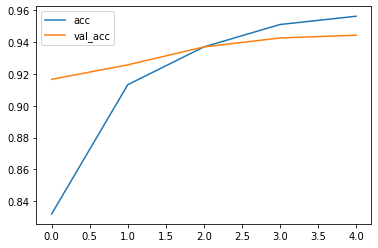

In [49]:
plt.plot(history.history['accuracy'], label='acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.legend()
plt.show()

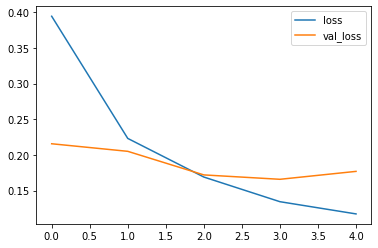

In [50]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

In [51]:
def predict_sentiment(text):
    tw = tokenizer.texts_to_sequences([text])
    tw = pad_sequences(tw,maxlen=200)
    prediction = int(model.predict(tw).round().item())
    print("Predicted label: ", sentiment_label[1][prediction])

In [52]:
text = input("Enter any sentiment about a flight:")
predict_sentiment(text)

Enter any sentiment about a flight:I loved the flight
Predicted label:  positive


# Conclusion

We build a tensorflow model using sequent model and embedding layers, while passing a sigmoid activation to compute the output. Our loss function was binary cross-entropy with an optimizer of adam. We used the accuracy metrics to  evaluate the performance of the model. The model did not perform well with an accuracy of 78% and validation accuracy of 85%.

We tuned the hyperparameters and added a spatial dropout  and dropout to reduce the probability of the neurals learning from each other. We also used LSTM as an hyperparameter. Our model accuracy increased to 95% and validation accuracy to 94%.  The loss and validation loss also reduced significantly.


# Recommendation

1. We recommend that the airlines to educate their staff on customer services. 
2. The airlines should  communication in case of any flight delays.
3. The airlines should make advanced communication in case any flight is to be canceled. 
